# Visualized data

In [8]:
%load_ext autoreload
%autoreload 2

import utils
import run
import evaluate

import numpy as np
import torch
import matplotlib.pyplot as plt

config = run.make_config('configs/horizonlstm_position.yaml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
using cpu


In [9]:
#torch_dict = torch.load('models/horizonlstm_position_gaussian_lr0.001-l4-h200-gaussian_04-12-2023_17-56-53_e200.p', map_location=torch.device('cpu'))
#torch_dict = torch.load('models/horizonlstm_position_gaussian_lr0.001-l4-h200-gaussian_05-12-2023_14-30-02_e440.p', map_location=torch.device('cpu'))
torch_dict = torch.load('models/horizonlstm_position_lr0.001-l4-h200-mse_29-11-2023_21-02-50_e3600.p', map_location=torch.device('cpu'))
#torch_dict = torch.load('models/horizonlstm_position_ws_lr1e-05-l4-h200-mse_18-12-2023_21-04-30_e2400.p', map_location=torch.device('cpu'))

In [10]:
import models
#config['model'] = models.HorizonLSTMWithVariance()
config['model'].load_state_dict(torch_dict['model_state_dict'], strict=False)

<All keys matched successfully>

In [11]:
def plot_trajectories(y_pred, y, x=None, delta_p=True, ax=None,):
    if delta_p:
        y_pred = np.vstack([[0, 0, 0], np.cumsum(y_pred, axis=0)])
        y = np.vstack([[0, 0, 0], np.cumsum(y, axis=0)])
    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(y_pred[:, 0], y_pred[:, 1], "--", label="pred")
    ax.plot(y[:, 0], y[:, 1], "--", label="gt")
    if x is not None:
        ax.plot(x[:, 0], x[:, 1], "-o", label="x")
    
    ax.set_aspect('equal', adjustable='datalim')
    
    ax.legend()

def plot_compensated_error_vectors(y_pred, y, points=10, ax=None):
    if points is None:
        points = y_pred.shape[0]
    ce = utils.compensate_error(y_pred, y)
    y_pred = np.vstack([[0, 0, 0], np.cumsum(y_pred, axis=0)])
    y = np.vstack([[0, 0, 0], np.cumsum(y, axis=0)])
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(y_pred[:points, 0], y_pred[:points, 1], '-o', label='y_pred')  # last point has no comparison since it is from the last predicted output, so no other gt-point to go to
    ax.plot(y[:points + 1, 0], y[:points + 1, 1], '-o', label='y')
    for i in range(points):
        ep = y_pred[i] + ce[i]
        plt.plot([y_pred[i, 0], ep[0]], [y_pred[i, 1], ep[1]])
    ax.legend()

def get_car_frame_error(y_pred, y, r):
    rr = np.array([[np.cos(r), -np.sin(r)], [np.sin(r), np.cos(r)]]).transpose(2, 0, 1)
    sr = (y - y_pred)[:, :2]
    return np.einsum('BNi, Bi->BN', rr, sr)

time to complete 0.028975
18 4194
world frame error (max, mean): [667.71103199 165.73162792   1.90478151] [417.526307    45.14169777   0.7240464 ]
car frame error (max, mean): [154.59080254 667.08137058] [ 44.52324421 418.35326557]


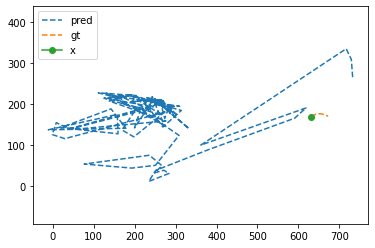

In [13]:
i = np.random.randint(len(config['train_datasets']))
j = np.random.randint(len(config['train_datasets'][i]))

x, y = config['train_datasets'][i][j]

y *= config['train_datasets'][i].p_r

###
import time

a = time.time()
y_pred = config['model'].generate(torch.tensor(x[:config['window']]).float(), torch.tensor(x[config['window']:, 3:]).float())
#y_pred = config['model'].generate(torch.tensor(x[:20]).float(), torch.tensor(x[20:30, 3:]).float())
y_pred = y_pred.detach().numpy() * config['train_datasets'][i].p_r
b = time.time()
print('time to complete %f' % (b - a))

###

x = x[:, :3] * config['train_datasets'][i].p_r
y = y[-config['horizon']:]

print(i, j)
plot_trajectories(y_pred, y, x=x[:config['window']], delta_p=config['delta_p'])
#plot_trajectories(y , y, delta_p=config['delta_p'])

print('world frame error (max, mean):', np.max(np.abs(y_pred - y), axis=0), np.mean(np.abs(y_pred - y), axis=0))
cfe = get_car_frame_error(y_pred, y, x[-config['horizon']:, -1])
print('car frame error (max, mean):', np.max(np.abs(cfe), axis=0), np.mean(np.abs(cfe), axis=0))

In [29]:
x, _ = config['train_datasets'][i][j]
x = x[:21]
dx = x[1:] - x[:-1]

# dx
print(dx[:, :3] * config['train_datasets'][i].p_r * 20)

# v
print(x[:, 3:6])

[[-20.35518084  -1.33791801  -0.26797347]
 [-20.31478911  -1.36650684  -0.20349574]
 [-20.34823577  -1.31586758  -0.26609302]
 [-20.34823577  -1.31586758  -0.26609302]
 [-20.39457043  -1.34430656  -0.30463285]
 [-20.3162599   -1.34648615  -0.17847635]
 [-20.32556103  -1.30866465  -0.29947205]
 [-20.33153495  -1.34094717  -0.20791681]
 [-20.36177381  -1.2707567   -0.38106727]
 [-20.41776594  -1.43122879  -0.33144015]
 [-20.41776594  -1.43122879  -0.33144015]
 [-20.32064831  -1.35189811  -0.27507103]
 [-20.33107524  -1.33691612  -0.35258609]
 [-20.33107524  -1.33691612  -0.35258609]
 [-20.37152169  -1.37957866  -0.44264716]
 [-20.38097305  -1.34512027  -0.24986393]
 [-20.37509601  -1.41274141  -0.3374792 ]
 [-20.34555503  -1.34074602  -0.32994223]
 [-20.3418945   -1.4290735   -0.42588978]
 [-20.34413316  -1.4295012   -0.31418442]]
[[-20.34362089  -1.33053514  -0.28937145]
 [-20.35507057  -1.33796141  -0.26791256]
 [-20.31467884  -1.36655005  -0.20343514]
 [-20.31467884  -1.36655005  -0.2

In [16]:
config['train_datasets'][i].v_mean

array([ 0.03677948,  0.00176562, -0.00011601])

In [2]:
i = np.random.randint(len(config['train_datasets']))
#i = 1
j = np.random.randint(len(config['train_datasets'][i]))
#j = 4935

print(config['train_datasets'][i].name)

x, y = config['train_datasets'][i][j]

y *= config['train_datasets'][i].p_r
y_pred = config['model'](torch.tensor(x).float())

var = y_pred.detach().numpy()[:, 3:]# * config['train_datasets'][i].p_r
y_pred = y_pred.detach().numpy()[:, :3] * config['train_datasets'][i].p_r

x = x[:, :3] * config['train_datasets'][i].p_r
y = y[-config['horizon']:]

print(i, j)
plot_trajectories(y, y_pred, x=None, delta_p=config['delta_p'])
#plot_trajectories(y , y, delta_p=config['delta_p'])

print(var.mean(axis=0))

#print('world frame error (max, mean):', np.max(np.abs(y_pred - y), axis=0), np.mean(np.abs(y_pred - y), axis=0))
#cfe = get_car_frame_error(y_pred, y, x[-config['horizon']:, -1])
#print('car frame error (max, mean):', np.max(np.abs(cfe), axis=0), np.mean(np.abs(cfe), axis=0))

NameError: name 'np' is not defined

In [200]:
print(config['train_datasets'][i].p_r)

[1516.40807653  527.96234116   10.61343846]


In [38]:
y_pred

array([[807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035195,   2.64065395],
       [807.88413413, 101.04035